In [1]:
import pandas as pd
from datapreprocessfunction_code import function_process, readfile, rename_cols,annon,outers_join,add_column,label_paths
import seaborn as sns
from matplotlib import pyplot as plt
import os
import numpy as np
from plots_functions import plot3d
from collections import OrderedDict
import cmath
from sklearn.decomposition import PCA

def PCA_target_maker(df,metadata):
    target = pd.DataFrame(df.columns)
    target = rename_cols(target,0,"barcode")
    target_types = pd.merge(target,metadata[["sample_type","barcode"]],on="barcode")
    return(target_types)

def PCA_target_maker_for_subtypes(df,sample_metadata_subtypes):
    target = pd.DataFrame(df.columns)
    target = rename_cols(target,0,"barcode")
    target_subtypes = pd.merge(target,sample_metadata_subtypes[["type","barcode"]],on="barcode")
    return(target_subtypes)

def raw_count_input_for_PCA(matrix,brca_all_de,PC_ref,lncRNAs_ref):
    """
    Making matrix with gene count for DE PC and lncRNAs
    """
    brca_all_PC      = annon(brca_all_de[["gene_id"]],"gene_id",PC_ref[["gene_id"]])
    brca_all_lncRNAs = annon(brca_all_de[["gene_id"]],"gene_id",lncRNAs_ref[["gene_id"]]) 
    matrix_PC        = annon(brca_all_PC,"gene_id",matrix)
    matrix_lncRNAs   = annon(brca_all_lncRNAs,"gene_id",matrix)
    return(matrix_lncRNAs,matrix_PC)

def normalize_input_for_PCA(brca_all_de,PC_ref,lncRNAs_ref):
    """
    Making matrix with gene count for DE PC and lncRNAs
    """
    brca_all_PC      = annon(brca_all_de,"gene_id",PC_ref[["gene_id"]])
    brca_all_lncRNAs = annon(brca_all_de,"gene_id",lncRNAs_ref[["gene_id"]]) 
    brca_all_PC.set_index('gene_sym',inplace=True)
    brca_all_lncRNAs.set_index('gene_sym',inplace=True)
    brca_all_lncRNAs.drop(["external_gene_name","logFC","AveExpr","P.Value",
                           "adj_pval","chr","start","end","gene_id"],axis=1,inplace =True)
    brca_all_PC.drop(["external_gene_name","logFC","AveExpr","P.Value",
                      "adj_pval","chr","start","end","gene_id"],axis=1,inplace =True)
    return(brca_all_lncRNAs,brca_all_PC)

def plot3d(PC_de,colors,title):
    fig    = plt.figure(figsize=(8,10))
    groups = PC_de.groupby('group')
    ax     = fig.add_subplot(111, projection='3d')
    ax.w_xaxis.set_pane_color((0.1,0.1,0.1,0.1))
    ax.w_yaxis.set_pane_color((0.1,0.1,0.1,0.1))
    ax.w_zaxis.set_pane_color((0.1,0.1,0.1,0.1))
    for name, group in groups:
        ax.scatter(group.PC1, group.PC2, group.PC3,label=name,color=colors[name])
        ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')   
    ax.title.set_text(title)
    
def PCA_components(df,target):
    pca = PCA(n_components=3)
    df_T =df.transpose()
    principalComponents = pca.fit_transform(df_T)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['PC1', 'PC2','PC3'])
    finalDf = pd.concat([principalDf, target[['sample_type']]], axis = 1)
    finalDf = rename_cols(finalDf,"sample_type","group")
    return finalDf

def plot2d(title,targets,colors,df):
    fig = plt.figure(figsize = (7,7))
    ax  = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 10)
    ax.set_ylabel('Principal Component 2', fontsize = 10)
    ax.set_title(title, fontsize = 10)
    for target, color in zip(targets,colors):
        indicesToKeep = df['group'] == target
        ax.scatter(df.loc[indicesToKeep, 'PC1']
               , df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
    ax.legend(targets,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid()
    return 

<Figure size 576x720 with 0 Axes>

In [2]:
path          = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/'
output        = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/output/plots/pca/'
BRCA_matrix   = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/matrix/'
BRCA_de       = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/'
PCA_lncRNAs   = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/PCAs_R/'
sample_meta   = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/autoencoder_lncRNAs/data/brca_suntypes/'

In [3]:
%store -r sample_metadata_subtypes

In [4]:
cancer_hallmarks = readfile(path,"Cancer_Hallmark.txt")
BRCA             = readfile(BRCA_matrix,"TCGA-BRCA.tsv")
BRCA_De          = readfile(BRCA_de,"lncRNA_0.58_TCGA-BRCA_DE")

In [5]:
pca_lncRNAs      = readfile(PCA_lncRNAs,"cancer_hallmarks_brca_lncRNAs_PCS")
pca_de_lncRNAs   = readfile(PCA_lncRNAs,"cancer_hallmarks_brca_de_lncRNAs_PCS")
pca_brca_samples = readfile(PCA_lncRNAs,"cancer_hallmarks_brca_lncRNAs_samples_PCS")
pca_lncRNAs.reset_index(inplace=True)

In [6]:
%store -r lncRNAs_ref
BRCA  = rename_cols(BRCA,'index','gene_sym')
BRCA  = rename_cols(BRCA,'gene_sym','gene_id')
BRCA  = BRCA.reset_index()

In [7]:
CH = (cancer_hallmarks.assign(LncRNA = cancer_hallmarks['LncRNA'].str.split(';'))
                    .explode('LncRNA')
                    .reset_index(drop=True))
CH['LncRNA'].replace('', np.nan, inplace=True)
CH = CH[["Set","LncRNA"]]
CH['LncRNA']      = CH['LncRNA'].apply(lambda x: x.strip())
CH = rename_cols(CH,"LncRNA","gene_sym")


SyntaxError: EOL while scanning string literal (<ipython-input-7-2274d1fe4d59>, line 1)

In [8]:
CH.shape

(780, 2)

In [10]:
Can_hall = (CH.groupby('gene_sym')['Set'].
        apply(lambda x: ', '.join(x.astype(str))).reset_index())
Can_hall['Set']= Can_hall['Set'].str.replace(', ','_')
Can_hall

,gene_sym,Set
0,91H,proliferation_migration_metastasis_prognosis
1,AB073614,proliferation_invasion_prognosis
2,AB209630,proliferation_apoptosis_invasion_prognosis
3,AC096677.3-201,proliferation_apoptosis_migration_invasion
4,AC104699.1.1,prognosis
...,...,...
279,n377360,proliferation
280,ncRAN,proliferation_migration_invasion_prognosis
281,p21,proliferation_apoptosis_prognosis
282,uc.63,apoptosis


In [12]:
BRCA

,index,TCGA-C8-A278-01A-11R-A169-07,TCGA-A7-A425-01A-11R-A24H-07,TCGA-E2-A15H-01A-11R-A12D-07,TCGA-A8-A06N-01A-11R-A00Z-07,TCGA-E2-A570-01A-11R-A29R-07,TCGA-BH-A1FL-01A-11R-A13Q-07,TCGA-E2-A56Z-01A-12R-A29R-07,TCGA-E9-A1RI-01A-11R-A169-07,TCGA-BH-A0DP-01A-21R-A056-07,...,TCGA-E9-A1RI-11A-41R-A169-07,TCGA-AC-A23H-11A-12R-A157-07,TCGA-E9-A1ND-11A-43R-A144-07,TCGA-BH-A0BZ-11A-61R-A12P-07,TCGA-BH-A18P-11A-43R-A12D-07,TCGA-BH-A0DZ-11A-22R-A089-07,TCGA-E2-A153-11A-31R-A12D-07,TCGA-BH-A0E0-11A-13R-A089-07,TCGA-A7-A13G-11A-51R-A13Q-07,TCGA-BH-A0B7-11A-34R-A115-07
0,ENSG00000000003,3655,1314,1379,3288,4394,6961,915,1980,2920,...,7639,7362,2433,4854,4483,3932,2797,3757,4611,3846
1,ENSG00000000005,3,412,6,2,1,81,11,5,27,...,3541,234,880,4164,697,46,36,254,869,107
2,ENSG00000000419,4030,1845,1660,3370,2196,2389,2309,2885,1322,...,1999,1813,1248,1658,1436,1244,1336,1585,1896,1713
3,ENSG00000000457,3514,2111,1744,4290,2831,4781,1434,2538,2342,...,1287,1684,738,1509,1283,1205,1698,1259,1262,2052
4,ENSG00000000460,1110,710,615,1211,677,1355,367,741,851,...,290,390,196,314,246,249,315,198,256,344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56443,ENSG00000281904,0,3,0,1,0,2,0,0,0,...,4,1,2,1,5,0,0,0,0,0
56444,ENSG00000281909,0,0,1,1,4,6,0,1,2,...,0,1,1,2,0,0,2,0,0,0
56445,ENSG00000281910,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
56446,ENSG00000281912,223,89,95,340,82,128,110,111,94,...,31,77,72,74,86,118,68,91,39,135


In [14]:
lncRNAs_brca       = annon(BRCA,"gene_id",lncRNAs_ref[["gene_id","gene_sym"]])
lncRNAs_brca_CH    = annon(CH[["gene_sym"]],"gene_sym",lncRNAs_brca)
lncRNAs_brca_CH_de = annon(lncRNAs_brca_CH,"gene_sym",BRCA_De[["gene_sym"]])

In [65]:
lncRNAs_brca_CH_de.drop_duplicates().to_csv(BRCA_de + 'cancer_hallmarks_brca_de_lncRNAs', sep='\t',index=False)

In [19]:
lncRNAs_brca_CH_de.drop_duplicates().shape

(56, 1218)

PCA

In [ ]:
pca     = PCA(n_components=2)
#lncRNAs = lncRNAs.transpose()
principalComponents_down             = pca.fit_transform(lncRNAs_down)
principalDf_down = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
target  = pd.DataFrame(lncRNAs_down.index)
target  = rename_cols(target,0,"group")
finalDf_down = pd.concat([principalDf_down, target[['gene_sym']]], axis = 1)

target_d = ['Proteoglycans',
 'Regulation',
 'Axon',
 'Cell',
 'Pathways',
 'Breast',
 'Hippo',
 'PI3K-Akt',
 'Rap1',
 'MAPK',
 'Calcium',
 'Acute',
 'cGMP-PKG',
 'Transcriptional',
 'Leukocyte',
 'ECM-receptor',
 'Cytokine-cytokine',
 'Small',
 'p53',
 'TNF',
 'PPAR']
colors_d  = ['darkblue','#22d8c3','purple','red','olive','yellow','tan','lime','violet',
          'seagreen','navy','lavender','indigo','plum','peru','coral',
          'silver','indianred','cyan','aqua','orchid']
finalDf_down = pd.merge(finalDf_down,pathway_cor_down[["gene_sym","term_name"]], on="gene_sym")
finalDf_down = rename_cols(finalDf_down,"term_name","group")

In [ ]:
pca     = PCA(n_components=2)
#lncRNAs = lncRNAs.transpose()
principalComponents             = pca.fit_transform(lncRNAs_up)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
target  = pd.DataFrame(lncRNAs_up.index)
target  = rename_cols(target,0,"group")
finalDf = pd.concat([principalDf, target[['gene_sym']]], axis = 1)

targets = ['PI3K-Akt',
 'Proteoglycans',
 'ECM-receptor',
 'Axon',
 'Cytokine-cytokine',
 'Pathways',
 'Cell',
 'MAPK',
 'Hippo',
 'Transcriptional',
 'Acute',
 'Leukocyte',
 'TNF',
 'PPAR',
 'Small',
 'Regulation',
 'p53',
 'DNA',
 'Breast',
 'Rap1',
 'Calcium',
 'cGMP-PKG']
colors  = ['darkblue','#22d8c3','purple','red','olive','yellow','tan','lime','violet',
          'seagreen','navy','lavender','indigo','plum','peru','coral',
          'silver','indianred','cyan','aqua','orchid','crimson']
finalDf = pd.merge(finalDf,pathway_cor_up[["gene_sym","term_name"]], on="gene_sym")
finalDf = rename_cols(finalDf,"term_name","group")

In [ ]:
plot2d("PCA on up regulated lncRNAs pathways on BRCA ",targets,colors,finalDf)
plt.savefig(ouput +"/pca/"+"BRCA_PCA_up_pathways.png")
plot2d("PCA on down regulated lncRNAs pathways on BRCA ",target_d,colors,finalDf_down)
plt.savefig(ouput +"/pca/"+"BRCA_PCA_down_pathways.png")

In [ ]:
targets = ["No","somatic"]
colors  = ['darkblue','#22d8c3']
plot2d("PCA on somatic mutated and non-mutated lncRNAs on BRCA samples ",targets,colors,finalDf)

In [ ]:
f = plt.figure(figsize=[50,30])
sns.set(font_scale = 2)
ax = sns.boxplot(x="external_gene_name", y="value", hue="sample_type",
                 data=lncRNAs_mutated_exp_m, palette="Set3")
plt.setp(ax.get_xticklabels(), rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.rcParams["axes.labelsize"] = 15
f.tight_layout()

In [ ]:
#fig, axes = plt.subplots(nrows=1, ncols=1)
targets = ['Primary Tumor', 'Solid Tissue Normal']
colors  = ['#22d8c3','deeppink']
plot2d("PCA on DE lncRNAs with pathways BRCA normalized",targets,colors,lnc_final_df_nrom_pathway)
plot2d("PCA on DE PCs BRCA normalized",targets,colors,pc_final_df_nrom)

PCA on lncRNAs and protein coding genes for the BRCA subtypes

In [ ]:
targets = ['luminalA', 'HER2','basallike','LuminalB','normallike']
colors  = ['darkblue','#22d8c3','purple','deeppink','red']
#plt.subplot(2, 1, 1)
plot2d("PCA on DE lncRNAs BRCA normalized for subtypes pathways ",targets,colors,lnc_final_df_nrom_st_path)
#plt.subplot(2, 1, 2)
plot2d("PCA on DE PC BRCA normalized for subtypes",targets,colors,pc_final_df_nrom_st)

PCA on lncRNAs which are enriched in cancer hallmarks for BRCA

In [121]:
pca_lncRNAs     = rename_cols(pca_lncRNAs,"index","gene_sym")
pca_lncRNAs = annon(pca_lncRNAs_pcs,"gene_sym",Can_hall)
pca_lncRNAs = rename_cols(pca_lncRNAs,"Set","group")
pca_plot = pca_lncRNAs[["PC1","PC2","PC3","gene_sym","group"]]

In [197]:
color_labels = pca_plot['group'].unique()
NUM_COLORS   = 37
clrs1        = sns.color_palette('plasma',n_colors=NUM_COLORS)

clrs         = sns.color_palette('husl', n_colors=NUM_COLORS) 
# Map label to RGB
color_map   = dict(zip(color_labels, clrs1))
color_map

{'proliferation_apoptosis_migration_EMT_invasion_metastasis_prognosis': (0.115124,
  0.023556,
  0.555468),
 'proliferation_apoptosis_migration_EMT_prognosis': (0.171574,
  0.019706,
  0.580806),
 'proliferation_apoptosis_EMT_invasion': (0.221197, 0.016497, 0.602083),
 'proliferation_apoptosis_migration_invasion_prognosis': (0.261183,
  0.013308,
  0.617911),
 'proliferation_apoptosis_migration_invasion': (0.30621, 0.008902, 0.633694),
 'proliferation_migration_invasion': (0.35015, 0.004382, 0.646298),
 'proliferation_migration_prognosis': (0.393304, 0.001114, 0.655199),
 'proliferation_apoptosis_migration_invasion_metastasis_prognosis': (0.429719,
  0.000831,
  0.659425),
 'proliferation_migration_invasion_prognosis': (0.471457, 0.005678, 0.659897),
 'proliferation_apoptosis_migration_EMT_invasion_prognosis': (0.512206,
  0.018833,
  0.655209),
 'proliferation_invasion': (0.551715, 0.043136, 0.645277),
 'proliferation': (0.584391, 0.068579, 0.632812),
 'proliferation_prognosis': (0.62

In [ ]:
pca_brca_samples.reset_index(inplace=True)
pca_brca_samples = rename_cols(pca_brca_samples,"index","barcode")
pca_brca_samples = annon(pca_brca_samples,"barcode",sample_metadata_subtypes[["barcode","sample_type"]])
plot = pca_brca_samples[["PC1","PC2","PC3","sample_type"]]
plot = rename_cols(plot,"sample_type","group")


In [229]:
pca_brca_samples = rename_cols(pca_brca_samples,"sample_type","group")
plot_subtypes    = annon(pca_brca_samples,"barcode",sample_metadata_subtypes[["barcode","sample_type"]])

In [243]:
plot_subtypes    = annon(pca_brca_samples,"barcode",sample_metadata_subtypes[["barcode","type"]])
plot_subtypes.drop('group',axis=1,inplace=True)

In [244]:
plot_subtypes = rename_cols(plot_subtypes,"type","group")
plot_subtypes

,barcode,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,group
0,TCGA-C8-A278-01A-11R-A169-07,0.030890,0.010178,-0.023058,0.028887,-0.002045,0.022697,-0.005710,-0.009116,-0.021874,...,-0.004853,-0.001752,-0.025359,0.009208,0.007287,-0.011262,0.000262,-0.002125,-0.643071,Her2
1,TCGA-A7-A425-01A-11R-A24H-07,0.027559,-0.049914,0.022821,-0.002897,0.012671,-0.000963,0.002882,0.004032,0.005442,...,0.008659,-0.001519,0.001172,0.001600,-0.005424,-0.008171,-0.004169,-0.003293,-0.393145,LumA
2,TCGA-E2-A15H-01A-11R-A12D-07,0.030968,-0.027076,0.020876,0.001740,0.002146,0.011740,-0.000093,0.006797,0.007661,...,0.019291,0.007053,0.018219,0.004675,-0.002642,-0.012070,0.004805,-0.004323,-0.029249,LumA
3,TCGA-A8-A06N-01A-11R-A00Z-07,0.028508,-0.019895,-0.023827,-0.061807,0.025910,0.018196,-0.007541,0.004831,0.025118,...,0.003924,-0.002644,0.015466,-0.000632,-0.001700,0.003610,0.008330,-0.009553,-0.051138,LumB
4,TCGA-E2-A570-01A-11R-A29R-07,0.028033,-0.045912,0.026357,0.001914,0.016746,0.010730,-0.005552,0.007572,-0.004946,...,-0.002559,-0.003485,-0.013303,-0.001517,-0.008790,-0.004013,-0.003277,0.006692,-0.041569,LumA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,TCGA-BH-A0DZ-11A-22R-A089-07,0.025356,0.035049,0.051844,-0.012739,-0.019718,-0.024537,0.095610,-0.008623,0.018926,...,-0.006897,-0.010371,-0.006712,-0.007168,0.001121,-0.002465,0.012438,0.003754,0.000449,Solid Tissue Normal
1226,TCGA-E2-A153-11A-31R-A12D-07,0.030391,-0.030135,0.008043,0.023483,-0.021520,0.007402,0.004999,0.010057,0.008650,...,0.014379,-0.001932,0.022952,0.009842,-0.000033,0.004961,-0.005118,0.007118,0.007493,Solid Tissue Normal
1227,TCGA-BH-A0E0-11A-13R-A089-07,0.026822,0.029278,0.046779,-0.019593,-0.021684,-0.028480,0.075598,-0.031134,-0.014241,...,0.028076,-0.008539,-0.001712,-0.005372,0.001146,-0.001684,0.007881,-0.001553,0.000459,Solid Tissue Normal
1228,TCGA-A7-A13G-11A-51R-A13Q-07,0.030375,-0.034401,-0.007959,0.004536,-0.013330,-0.010843,-0.001689,0.011904,-0.012829,...,0.006699,-0.005595,0.008312,0.001239,0.000537,-0.000337,-0.007208,0.001247,-0.009992,Solid Tissue Normal


In [245]:
plot_subtypes.group.drop_duplicates()

0                      Her2
1                      LumA
3                      LumB
7             Primary Tumor
12                    Basal
22               normallike
1117    Solid Tissue Normal
Name: group, dtype: object

In [247]:
color_labels = plot_subtypes['group'].unique()

NUM_COLORS   = 7
clrs1        = sns.color_palette('plasma',n_colors=NUM_COLORS)
color_map    = dict(zip(color_labels, clrs1))


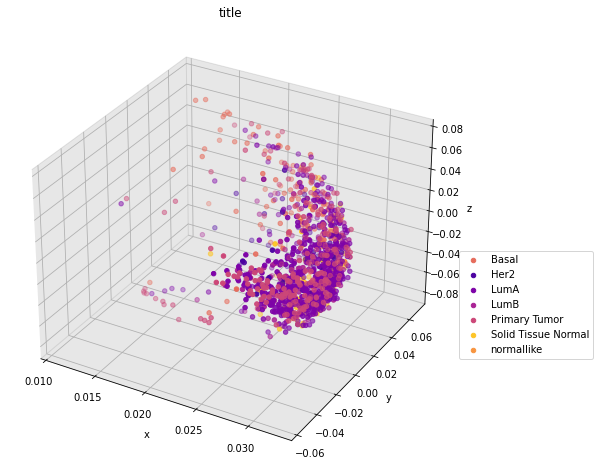

In [249]:
fig    = plt.figure(figsize=(8,10))
groups = plot_subtypes.groupby('group')
ax     = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color((0.1,0.1,0.1,0.1))
ax.w_yaxis.set_pane_color((0.1,0.1,0.1,0.1))
ax.w_zaxis.set_pane_color((0.1,0.1,0.1,0.1))

for name, group in groups:
    ax.scatter(group.PC1, group.PC2, group.PC3,label=name,color=color_map[name])
    ax.legend(bbox_to_anchor=(1, 0.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')   
ax.title.set_text("title")

In [223]:
plot

,PC1,PC2,PC3,group
0,0.030890,0.010178,-0.023058,Primary Tumor
1,0.027559,-0.049914,0.022821,Primary Tumor
2,0.030968,-0.027076,0.020876,Primary Tumor
3,0.028508,-0.019895,-0.023827,Primary Tumor
4,0.028033,-0.045912,0.026357,Primary Tumor
...,...,...,...,...
1215,0.025356,0.035049,0.051844,Solid Tissue Normal
1216,0.030391,-0.030135,0.008043,Solid Tissue Normal
1217,0.026822,0.029278,0.046779,Solid Tissue Normal
1218,0.030375,-0.034401,-0.007959,Solid Tissue Normal


,barcode,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,sample_type
0,TCGA-C8-A278-01A-11R-A169-07,0.030890,0.010178,-0.023058,0.028887,-0.002045,0.022697,-0.005710,-0.009116,-0.021874,...,-0.004853,-0.001752,-0.025359,0.009208,0.007287,-0.011262,0.000262,-0.002125,-0.643071,Primary Tumor
1,TCGA-A7-A425-01A-11R-A24H-07,0.027559,-0.049914,0.022821,-0.002897,0.012671,-0.000963,0.002882,0.004032,0.005442,...,0.008659,-0.001519,0.001172,0.001600,-0.005424,-0.008171,-0.004169,-0.003293,-0.393145,Primary Tumor
2,TCGA-E2-A15H-01A-11R-A12D-07,0.030968,-0.027076,0.020876,0.001740,0.002146,0.011740,-0.000093,0.006797,0.007661,...,0.019291,0.007053,0.018219,0.004675,-0.002642,-0.012070,0.004805,-0.004323,-0.029249,Primary Tumor
3,TCGA-A8-A06N-01A-11R-A00Z-07,0.028508,-0.019895,-0.023827,-0.061807,0.025910,0.018196,-0.007541,0.004831,0.025118,...,0.003924,-0.002644,0.015466,-0.000632,-0.001700,0.003610,0.008330,-0.009553,-0.051138,Primary Tumor
4,TCGA-E2-A570-01A-11R-A29R-07,0.028033,-0.045912,0.026357,0.001914,0.016746,0.010730,-0.005552,0.007572,-0.004946,...,-0.002559,-0.003485,-0.013303,-0.001517,-0.008790,-0.004013,-0.003277,0.006692,-0.041569,Primary Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,TCGA-BH-A0DZ-11A-22R-A089-07,0.025356,0.035049,0.051844,-0.012739,-0.019718,-0.024537,0.095610,-0.008623,0.018926,...,-0.006897,-0.010371,-0.006712,-0.007168,0.001121,-0.002465,0.012438,0.003754,0.000449,Solid Tissue Normal
1216,TCGA-E2-A153-11A-31R-A12D-07,0.030391,-0.030135,0.008043,0.023483,-0.021520,0.007402,0.004999,0.010057,0.008650,...,0.014379,-0.001932,0.022952,0.009842,-0.000033,0.004961,-0.005118,0.007118,0.007493,Solid Tissue Normal
1217,TCGA-BH-A0E0-11A-13R-A089-07,0.026822,0.029278,0.046779,-0.019593,-0.021684,-0.028480,0.075598,-0.031134,-0.014241,...,0.028076,-0.008539,-0.001712,-0.005372,0.001146,-0.001684,0.007881,-0.001553,0.000459,Solid Tissue Normal
1218,TCGA-A7-A13G-11A-51R-A13Q-07,0.030375,-0.034401,-0.007959,0.004536,-0.013330,-0.010843,-0.001689,0.011904,-0.012829,...,0.006699,-0.005595,0.008312,0.001239,0.000537,-0.000337,-0.007208,0.001247,-0.009992,Solid Tissue Normal
